<a href="https://www.kaggle.com/code/suyashkapil/covid-19-classification-cnn?scriptVersionId=122969824" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **COVID-19 classification based on Covid19-dataset**

# importing libraries

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_dir = '/kaggle/input/covid19-image-dataset/Covid19-dataset/train'
test_dir = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test'

In [3]:
x_train = []
for folder in os.listdir(train_dir):
    sub_path = train_dir + '/' + folder
    for image in os.listdir(sub_path):
        img_path = sub_path + '/' + image
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224)) #VGG19 needs an input of shape 224x224
        x_train.append(img)

In [4]:
x_test = []
for folder in os.listdir(test_dir):
    sub_test = test_dir + '/' + folder
    for image in os.listdir(sub_test):
        img_test = sub_test + '/' + image
        imgtest = cv2.imread(img_test)
        imgtest = cv2.resize(imgtest,(224,224))
        x_test.append(imgtest)

In [5]:
train = np.array(x_train)/255.0
test = np.array(x_test)/255.0

In [14]:
train_data = ImageDataGenerator(rescale = 1/255.0 , validation_split=0.2)
test_data = ImageDataGenerator(rescale = 1/255.0)

In [15]:
train_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'training',
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)
val_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'validation',
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)
test_set = test_data.flow_from_directory(
                    test_dir,
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [16]:
y_train = train_set.classes 
y_val = val_set.classes
y_test = test_set.classes 
print(train_set.class_indices)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


# First 8 images 

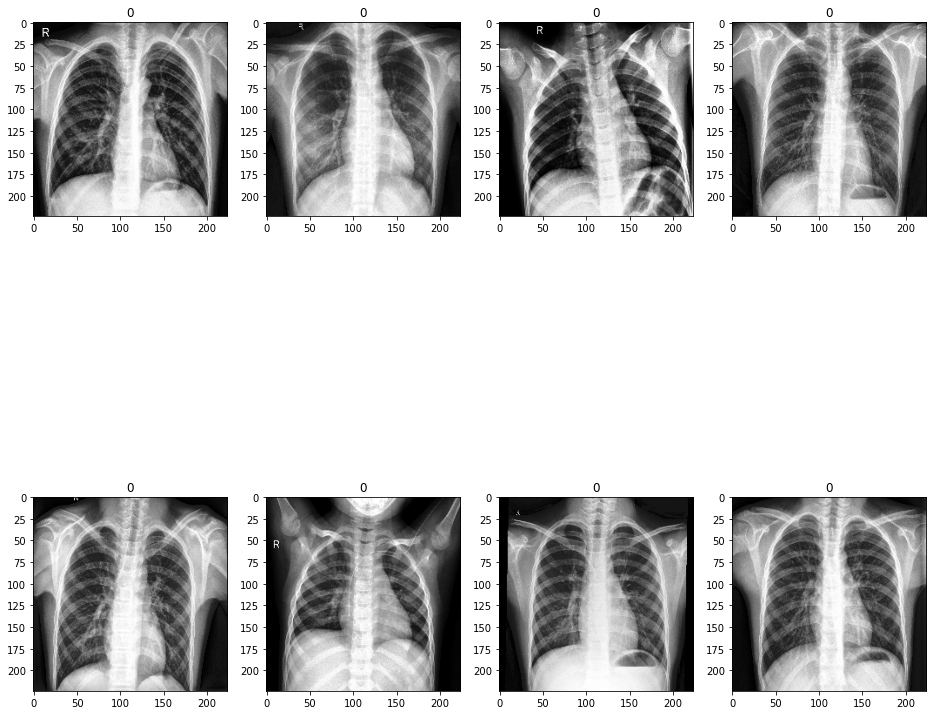

In [10]:
plt.figure(figsize=(16,16))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train[i])
    plt.title(y_train[i])

# Using VGG19

In [11]:
vgg = VGG19(include_top = False , input_shape = (224,224,3),weights='imagenet')
for layer in vgg.layers :
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [23]:
ES = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    verbose = 0
)
model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.2),
    vgg,
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)


# Fitting the model

In [34]:
training = model.fit_generator(
    train_set,
    callbacks=[ES],
    steps_per_epoch = 7 ,
    epochs = 100,
    validation_data = val_set
)

Epoch 1/100
7/7 [==============================] - 17s 3s/step - loss: 0.7835 - accuracy: 0.6667 - val_loss: 0.9527 - val_accuracy: 0.7400
Epoch 2/100
7/7 [==============================] - 11s 2s/step - loss: 0.5984 - accuracy: 0.8159 - val_loss: 0.5829 - val_accuracy: 0.7800
Epoch 3/100
7/7 [==============================] - 11s 2s/step - loss: 0.4667 - accuracy: 0.8060 - val_loss: 0.4881 - val_accuracy: 0.8000
Epoch 4/100
7/7 [==============================] - 11s 2s/step - loss: 0.4567 - accuracy: 0.8507 - val_loss: 0.5724 - val_accuracy: 0.7800
Epoch 5/100
7/7 [==============================] - 11s 2s/step - loss: 0.3266 - accuracy: 0.8955 - val_loss: 0.7436 - val_accuracy: 0.7400
Epoch 6/100
7/7 [==============================] - 11s 2s/step - loss: 0.2895 - accuracy: 0.8756 - val_loss: 0.4625 - val_accuracy: 0.7800
Epoch 7/100
7/7 [==============================] - 11s 2s/step - loss: 0.2151 - accuracy: 0.9303 - val_loss: 0.4562 - val_accuracy: 0.8600
Epoch 8/100
7/7 [==========

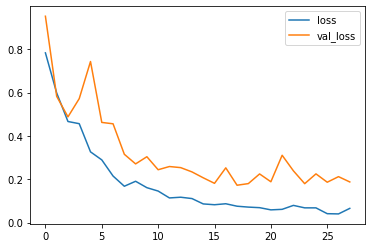

In [42]:
history_df = pd.DataFrame(training.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

# Prediction

In [48]:
pred = model.predict(test_set)
final_pred = np.argmax(pred, axis =1)